# Examine Predictive Performance Results for all Combinations (e.g. Rankings)

<hr/>

#### Imports

In [1]:
import collections

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#### Constants

In [2]:
DATA_FOLDER = '../../../data/generated_by_notebooks/'
PLOT_FOLDER = './plots/'

#### Settings

In [3]:
mpl.rcParams['figure.dpi'] = 200

algorithms = ['rf', 'xgb', 'svm_rbf', 'shallow', 'dropout']
algorithm_names = ['RF', 'XGB', 'SVM', 'Shallow', 'Deep']
algorithm_to_name = dict(zip(algorithms, algorithm_names))

descriptors = ['maccs', 'ecfc', 'rdkit', 'cddd']
descriptor_names = ['MACCS', 'MFC', 'RDKit', 'CDDD']
descriptor_to_name = dict(zip(descriptors, descriptor_names))

# Names of the datasets that were already run
dataset_names = [
    'tetrahymena',
    'freesolv',
    'esol',
    'MMP2',
    'IL4',
    'F7',
    'O60674',
    'O14965',
    'P03372',
    'P04150',
    'P06401',
    'P11229',
    'P12931',
    'P16581',
    'P17252',
    'P18089',
    'P19327',
    'P21554',
    'P24530',
    'P25929',
    'P28335',
    'P28482',
    'P35968',
    'P41594',
    'P42345',
    'P47871',
    'P49146',
    'P61169',
    'Q05397',
    'Q16602',
    'P24941',
    'Q92731'
]

#### Functions

In [4]:
def load_evaluation_matrix(name, evaluation='predictive', to_matrix=True):
    """Loads performance table for a single dataset."""
    path = f'{DATA_FOLDER}/{evaluation}_performances/{name}.csv'
    df = pd.read_csv(path, sep=';').set_index('descriptor')
    if to_matrix:
        matrix = df.to_numpy()
        return matrix
    else:
        return df
    
    
def find_all_below_or_above(tables, threshold, above=True, explicit=False):
    """Finds and reports all combinations above or below a given threshold."""
    def hit(value):
        if above:
            return value >= threshold
        else:
            return value <= threshold
    external_hit_counter = 0
    maximum_hit_counter = 0
    max_hits = len(descriptor_names) * len(algorithm_names)
    print('ANY | ALL | DESCRIPTION')
    print('---------------------------')
    for name in dataset_names:
        internal_hit_counter = 0
        exceptions = list()
        for i, descriptor in enumerate(descriptor_names):
            for j, algorithm in enumerate(algorithm_names):
                val = tables[name][i][j]
                if hit(val):
                    if explicit:
                        print(f'{dataset_name} {descriptor} {algorithm}: {val}')
                    internal_hit_counter += 1
                else:
                    exceptions.append(f'{descriptor}, {algorithm}')
        if internal_hit_counter > 0:
            indicator = ' X  | '
            external_hit_counter += 1
        else:
            indicator = '    | '
        if internal_hit_counter == max_hits:
            indicator += ' X  |'
            maximum_hit_counter += 1
        else:
            indicator += '    |'
        if internal_hit_counter == max_hits - 1:
            print(f'{indicator} {name}: {internal_hit_counter}, exception: {exceptions[0]}')
        else:
            print(f'{indicator} {name}: {internal_hit_counter}')
        if explicit:
            print()
    print()
    print(f'{external_hit_counter} for any.')
    print(f'{maximum_hit_counter} for all.')
    

# Copied from
# https://matplotlib.org/3.5.0/gallery/images_contours_and_fields/image_annotated_heatmap.html
# then changed.

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    #cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    #cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_xticklabels(col_labels, size=7)
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_yticklabels(row_labels, size=7)

    # Let the horizontal axes labeling appear on top.
    #ax.tick_params(top=False, bottom=False, left=False,
    #               labeltop=True, labelbottom=False)
    ax.tick_params(top=False, bottom=False, left=False,
                   labeltop=True, labelbottom=False)
    ax.tick_params(axis="y", pad=-2.)
    ax.tick_params(axis="x", pad=-3.)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), ha="center",
             rotation_mode="default")
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right",
            rotation_mode='anchor')

    # Turn spines off and create white grid.
    #ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]), minor=True)
    ax.set_yticks(np.arange(data.shape[0]), minor=True)

    #return im, cbar
    return im


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, inverse=False, underlining=False, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = mpl.ticker.StrMethodFormatter(valfmt)
        
    # Added: Underline best performing value
    best_i, best_j = np.where(data==data.max())
    best_i, best_j = best_i[0], best_j[0]
    mykwargs = {'size': 9, 'ha': 'center', 'va': 'center'}

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            # Original:
            #kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            # Changed:
            string = valfmt(data[i, j], None)
            if inverse:
                col = textcolors[int(im.norm(data[i, j]) > threshold)]
            else:
                col = textcolors[int(im.norm(data[i, j]) < threshold)]
            if i == best_i and j == best_j and underlining:
                text = im.axes.text(j, i, string, weight='bold', color=col, **mykwargs)
                underline = ''.join(['_' for char in range(len(string))])
                line = im.axes.text(j, i, underline, weight='bold', color=col, **mykwargs)
                texts.append(text)
                texts.append(line)
            else:
                text = im.axes.text(j, i, string, color=col, **mykwargs)
                texts.append(text)
            #kw.update(color=textcolors[int(im.norm(data[i, j]) < threshold)])
    return texts

<hr/>

#### Load data

In [5]:
performances = dict()

for dataset_name in dataset_names:
    df = load_evaluation_matrix(dataset_name, evaluation='predictive')
    performances[dataset_name] = df

<hr/>

### Evaluate

#### Inspect distribution

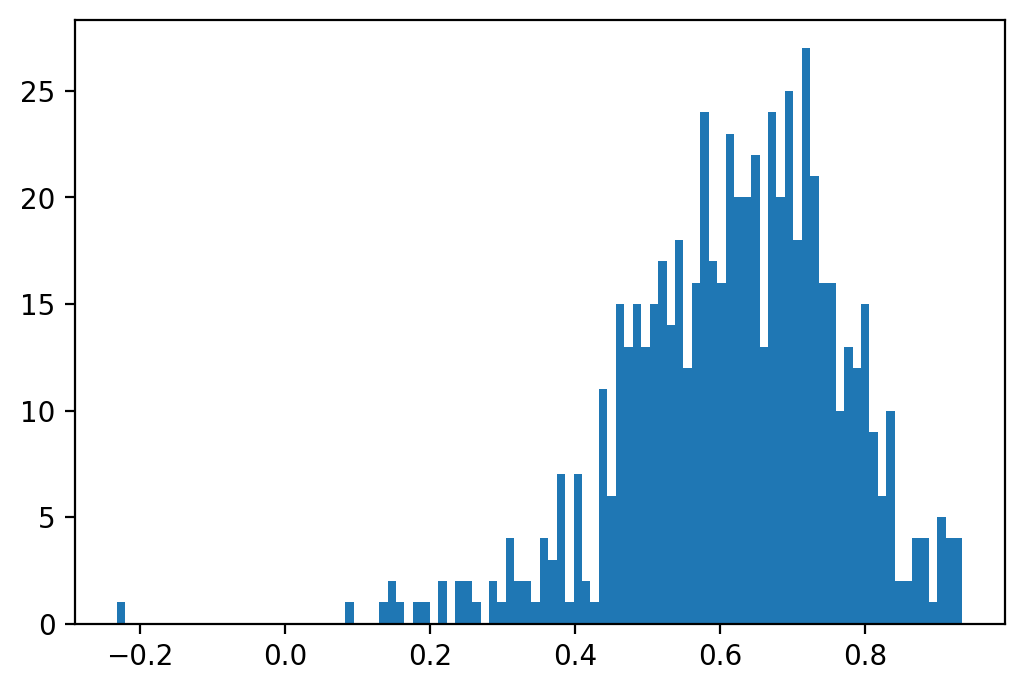

In [6]:
all_values_unraveled = list()

for dataset_name in dataset_names:
    for value in performances[dataset_name].reshape(-1):
        all_values_unraveled.append(value)

plt.hist(all_values_unraveled, bins=100)
plt.show()

In [7]:
med = np.median(all_values_unraveled)
print(med)

0.6332336832276874


#### $R^2$ above/below given threshold

In [8]:
find_all_below_or_above(performances, med)

ANY | ALL | DESCRIPTION
---------------------------
 X  |  X  | tetrahymena: 20
 X  |     | freesolv: 19, exception: MFC, SVM
 X  |     | esol: 19, exception: MFC, SVM
    |     | MMP2: 0
    |     | IL4: 0
 X  |     | F7: 13
    |     | O60674: 0
 X  |     | O14965: 11
 X  |     | P03372: 18
 X  |     | P04150: 12
 X  |     | P06401: 18
 X  |     | P11229: 17
 X  |     | P12931: 18
 X  |     | P16581: 6
 X  |     | P17252: 9
    |     | P18089: 0
 X  |     | P19327: 2
 X  |     | P21554: 18
 X  |     | P24530: 19, exception: MACCS, SVM
 X  |     | P25929: 18
    |     | P28335: 0
    |     | P28482: 0
 X  |     | P35968: 9
    |     | P41594: 0
 X  |     | P42345: 19, exception: MACCS, SVM
 X  |     | P47871: 1
 X  |     | P49146: 18
    |     | P61169: 0
    |     | Q05397: 0
 X  |     | Q16602: 19, exception: MACCS, SVM
 X  |     | P24941: 14
 X  |     | Q92731: 3

23 for any.
1 for all.


In [9]:
find_all_below_or_above(performances, med, above=False)

ANY | ALL | DESCRIPTION
---------------------------
    |     | tetrahymena: 0
 X  |     | freesolv: 1
 X  |     | esol: 1
 X  |  X  | MMP2: 20
 X  |  X  | IL4: 20
 X  |     | F7: 7
 X  |  X  | O60674: 20
 X  |     | O14965: 9
 X  |     | P03372: 2
 X  |     | P04150: 8
 X  |     | P06401: 2
 X  |     | P11229: 3
 X  |     | P12931: 2
 X  |     | P16581: 14
 X  |     | P17252: 11
 X  |  X  | P18089: 20
 X  |     | P19327: 18
 X  |     | P21554: 2
 X  |     | P24530: 1
 X  |     | P25929: 2
 X  |  X  | P28335: 20
 X  |  X  | P28482: 20
 X  |     | P35968: 11
 X  |  X  | P41594: 20
 X  |     | P42345: 1
 X  |     | P47871: 19, exception: MFC, XGB
 X  |     | P49146: 2
 X  |  X  | P61169: 20
 X  |  X  | Q05397: 20
 X  |     | Q16602: 1
 X  |     | P24941: 6
 X  |     | Q92731: 17

31 for any.
9 for all.


#### Homogeneity between $R^2$ values

In [10]:
diffs = list()

for dataset_name in dataset_names:
    matrix = performances[dataset_name]
    diff = matrix.max() - matrix.min()
    diffs.append(f'{diff} {dataset_name}:          {matrix.min()}, {matrix.max()}')
    
for diff in list(sorted(diffs)):
    print(diff)

0.15181971821824825 tetrahymena:          0.719900194803393, 0.8717199130216412
0.15849396448651043 P49146:          0.616740962553469, 0.7752349270399794
0.18183550921859482 P04150:          0.5104437382831484, 0.6922792475017432
0.1898666932225681 P11229:          0.5583013285249663, 0.7481680217475344
0.2028890672663649 P03372:          0.5421720864184335, 0.7450611536847984
0.22221059012700917 P06401:          0.5234713633165795, 0.7456819534435887
0.22248251953037335 P16581:          0.4786981415707726, 0.701180661101146
0.22926278817417367 P42345:          0.608833638473398, 0.8380964266475717
0.24978942985475272 P17252:          0.4383781099682318, 0.6881675398229845
0.2503707260564617 Q16602:          0.588623875520963, 0.8389946015774247
0.2551201708096322 P24941:          0.4701325343968233, 0.7252527052064555
0.2796275258276222 P12931:          0.4793880300982454, 0.7590155559258676
0.2830857923649913 P47871:          0.3562744746923, 0.6393602670572913
0.2871769518931384 P2

#### Best combinations

In [11]:
best_combinations = list()

for dataset_name in dataset_names:
    matrix = performances[dataset_name]
    i_, j_ = np.where(matrix==matrix.max())
    i, j = i_[0], j_[0]
    best_combinations.append(f'{descriptor_names[i]}, {algorithm_names[j]}')
    print(f'{dataset_name}: {descriptor_names[i]}, {algorithm_names[j]}')

tetrahymena: RDKit, Shallow
freesolv: RDKit, Shallow
esol: CDDD, Shallow
MMP2: MFC, Shallow
IL4: MFC, Shallow
F7: MFC, XGB
O60674: MFC, Deep
O14965: MFC, Deep
P03372: CDDD, Deep
P04150: CDDD, Deep
P06401: MFC, Deep
P11229: CDDD, Deep
P12931: CDDD, Deep
P16581: MFC, XGB
P17252: MFC, XGB
P18089: CDDD, XGB
P19327: MFC, Deep
P21554: CDDD, Deep
P24530: CDDD, Deep
P25929: MFC, Deep
P28335: CDDD, Deep
P28482: MFC, Deep
P35968: MFC, Deep
P41594: CDDD, Deep
P42345: MFC, Deep
P47871: MFC, XGB
P49146: CDDD, Deep
P61169: MFC, Deep
Q05397: MFC, Deep
Q16602: CDDD, Deep
P24941: MFC, Deep
Q92731: CDDD, Shallow


In [12]:
collections.Counter(best_combinations)

Counter({'RDKit, Shallow': 2,
         'CDDD, Shallow': 2,
         'MFC, Shallow': 2,
         'MFC, XGB': 4,
         'MFC, Deep': 11,
         'CDDD, Deep': 10,
         'CDDD, XGB': 1})

#### Worst combinations

In [13]:
worst_combinations = list()

for dataset_name in dataset_names:
    matrix = performances[dataset_name]
    i_, j_ = np.where(matrix==matrix.min())
    i, j = i_[0], j_[0]
    worst_combinations.append(f'{descriptor_names[i]}, {algorithm_names[j]}')
    print(f'{dataset_name}: {descriptor_names[i]}, {algorithm_names[j]}')

tetrahymena: MACCS, SVM
freesolv: MFC, SVM
esol: MFC, SVM
MMP2: RDKit, Shallow
IL4: RDKit, Shallow
F7: MACCS, Deep
O60674: MACCS, SVM
O14965: MACCS, SVM
P03372: MACCS, SVM
P04150: MACCS, SVM
P06401: MACCS, SVM
P11229: MACCS, SVM
P12931: MACCS, SVM
P16581: MACCS, SVM
P17252: MACCS, SVM
P18089: CDDD, Shallow
P19327: MACCS, SVM
P21554: MACCS, SVM
P24530: MACCS, SVM
P25929: MACCS, SVM
P28335: MACCS, SVM
P28482: MACCS, SVM
P35968: MACCS, SVM
P41594: MACCS, SVM
P42345: MACCS, SVM
P47871: MACCS, SVM
P49146: MACCS, Shallow
P61169: MACCS, SVM
Q05397: MACCS, SVM
Q16602: MACCS, SVM
P24941: MACCS, SVM
Q92731: MACCS, SVM


In [14]:
collections.Counter(worst_combinations)

Counter({'MACCS, SVM': 25,
         'MFC, SVM': 2,
         'RDKit, Shallow': 2,
         'MACCS, Deep': 1,
         'CDDD, Shallow': 1,
         'MACCS, Shallow': 1})

#### Find globally lowest/highest

In [15]:
lowest = 1.0
arg_lowest = ''
highest = -1.0
arg_highest = ''

for dataset_name in dataset_names:
    matrix = performances[dataset_name]
    current_lowest = matrix.min()
    current_highest = matrix.max()
    if current_lowest < lowest:
        lowest = current_lowest
        i_, j_ = np.where(matrix==lowest)
        i, j = i_[0], j_[0]
        arg_lowest = f'{dataset_name}, {descriptor_names[i]} & {algorithm_names[j]}'
    if current_highest > highest:
        highest = current_highest
        i_, j_ = np.where(matrix==highest)
        i, j = i_[0], j_[0]
        arg_highest = f'{dataset_name}, {descriptor_names[i]} & {algorithm_names[j]}'

In [16]:
print(f'Globally lowest:  {arg_lowest}  {lowest}')
print(f'Globally highest: {arg_highest}  {highest}')

Globally lowest:  MMP2, RDKit & Shallow  -0.2314771828802657
Globally highest: esol, CDDD & Shallow  0.934726276854192


#### Picking out points of interest

In [17]:
data_set_of_interest = 'tetrahymena'

min_val = performances[data_set_of_interest].min()
i_, j_ = np.where(performances[data_set_of_interest]==min_val)
i, j = i_[0], j_[0]
print(f'Smallest val for {data_set_of_interest} ({min_val}) with {descriptor_names[i]} & {algorithm_names[j]}')

max_val = performances[data_set_of_interest].max()
i_, j_ = np.where(performances[data_set_of_interest]==max_val)
i, j = i_[0], j_[0]
print(f'Largest val for {data_set_of_interest} ({max_val}) with {descriptor_names[i]} & {algorithm_names[j]}')

Smallest val for tetrahymena (0.719900194803393) with MACCS & SVM
Largest val for tetrahymena (0.8717199130216412) with RDKit & Shallow


In [18]:
data_set_of_interest = 'MMP2'

min_val = performances[data_set_of_interest].min()
i_, j_ = np.where(performances[data_set_of_interest]==min_val)
i, j = i_[0], j_[0]
print(f'Smallest val for {data_set_of_interest} ({min_val}) with {descriptor_names[i]} & {algorithm_names[j]}')

max_val = performances[data_set_of_interest].max()
i_, j_ = np.where(performances[data_set_of_interest]==max_val)
i, j = i_[0], j_[0]
print(f'Largest val for {data_set_of_interest} ({max_val}) with {descriptor_names[i]} & {algorithm_names[j]}')

Smallest val for MMP2 (-0.2314771828802657) with RDKit & Shallow
Largest val for MMP2 (0.5775065130720165) with MFC & Shallow


### "Success tables"

In [19]:
success_table = pd.DataFrame(np.zeros((len(descriptor_names), len(algorithm_names))), index=descriptor_names, columns=algorithm_names, dtype=int)
fail_table = pd.DataFrame(np.zeros((len(descriptor_names), len(algorithm_names))), index=descriptor_names, columns=algorithm_names, dtype=int)

best_dict = collections.Counter(best_combinations)
worst_dict = collections.Counter(worst_combinations)

for algorithm_name in algorithm_names:
    for descriptor_name in descriptor_names:
        lookup = f'{descriptor_name}, {algorithm_name}'
        success_table[algorithm_name][descriptor_name] = best_dict[lookup]
        fail_table[algorithm_name][descriptor_name] = worst_dict[lookup]

Plot and save

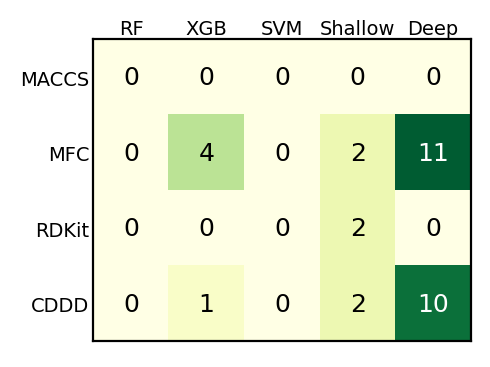

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(2.5, 2))
im = heatmap(success_table.to_numpy(), descriptor_names, algorithm_names, ax=ax, cmap='YlGn', cbarlabel=None)
texts = annotate_heatmap(im, valfmt="{x}", inverse=True, threshold=7)
im.set_clim(0, 12)
ax.set_title(None, size=7)
plt.savefig(PLOT_FOLDER+'summaries/r2_best.pdf', bbox_inches='tight', pad_inches=0.0)
plt.show()

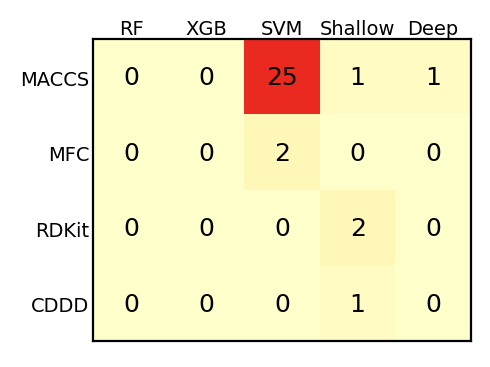

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(2.5, 2))
im = heatmap(fail_table.to_numpy(), descriptor_names, algorithm_names, ax=ax, cmap='YlOrRd', cbarlabel=None)
texts = annotate_heatmap(im, valfmt="{x}", threshold=0)
im.set_clim(0, 35)
ax.set_title(None, size=7)
plt.savefig(PLOT_FOLDER+'summaries/r2_worst.pdf', bbox_inches='tight', pad_inches=0.0)
plt.show()